In [ ]:
import torch
from torch import nn

import torchvision
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split


In [ ]:
hand_written_numbers = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16459833.05it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 494086.55it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4494711.61it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4217517.99it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
train_data = datasets.FashionMNIST(root="data",
                                   train=True,
                                   download=True,
                                   transform=ToTensor(),
                                   target_transform=None
                                   )

test_data = datasets.FashionMNIST(root="data",
                                  train=False,
                                  download=True,
                                  transform=ToTensor(),
                                  target_transform=None
                                  )

100%|██████████| 26421880/26421880 [00:02<00:00, 10389950.79it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 203782.62it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3714506.95it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21127472.59it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
image = train_data[0][0]

In [ ]:
class_names = train_data.classes
# class_names

In [ ]:
# converting data into batches
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
class FashionMNISTModel(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()


    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    x = self.classifier(x)
    return x


torch.manual_seed(42)
model = FashionMNISTModel(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)


## setting up loss function and optimizer

In [ ]:
import requests
from os import path

if path.exists("helper_functions.py"):
  print("helper function exists")

else :
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

from helper_functions import accuracy_fn

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [ ]:
# setup device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## training and testing loop

In [ ]:
def train_step(model:nn.Module, accuracy_fn, loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer, data_loader:torch.utils.data.DataLoader,
               device:torch.device = device):

  train_loss = 0
  accuracy = 0

  for batch,(X,y) in enumerate(data_loader):
    X,y = X.to(device), y.to(device)

    model.train()
    y_pred = model(X)

    loss = loss_fn(y_pred,y)
    train_loss+=loss
    accuracy += accuracy_fn(y_true=y,
                            y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/ {len(data_loader.dataset)} samples")

  print(f"device: {device} Train loss: {train_loss/len(data_loader):.5f} train accuracy:{accuracy/len(data_loader):.3f}%")



In [ ]:
def test_step(model:nn.Module, accuracy_fn, loss_fn:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               device:torch.device = device):

  test_loss = 0
  test_acc = 0
  for X,y in data_loader:
    X,y = X.to(device), y.to(device)
    model.eval()
    with torch.inference_mode():
      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1))


  print (len(data_loader))
  print(f"device: {device} test loss:{test_loss/len(data_loader):.5f}  test accuracy:{test_acc/len(data_loader):.3f}%")



In [ ]:
from tqdm.auto import tqdm

torch.manual_seed(42)
epochs = 10

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")
  train_step(model=model,
            accuracy_fn=accuracy_fn,
             loss_fn=loss_fn,
             optimizer=optimizer,
             data_loader=train_dataloader,
             device=device)

  test_step(model=model,
            accuracy_fn=accuracy_fn,
             loss_fn=loss_fn,
             data_loader=test_dataloader,
             device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/ 60000 samples
Looked at 12800/ 60000 samples
Looked at 25600/ 60000 samples
Looked at 38400/ 60000 samples
Looked at 51200/ 60000 samples
device: cuda Train loss: 0.31662 train accuracy:88.620%
313
device: cuda test loss:0.32076  test accuracy:88.788%
Epoch: 1
---------
Looked at 0/ 60000 samples
Looked at 12800/ 60000 samples
Looked at 25600/ 60000 samples
Looked at 38400/ 60000 samples
Looked at 51200/ 60000 samples
device: cuda Train loss: 0.29571 train accuracy:89.283%
313
device: cuda test loss:0.31240  test accuracy:88.758%
Epoch: 2
---------
Looked at 0/ 60000 samples
Looked at 12800/ 60000 samples
Looked at 25600/ 60000 samples
Looked at 38400/ 60000 samples
Looked at 51200/ 60000 samples
device: cuda Train loss: 0.28277 train accuracy:89.732%
313
device: cuda test loss:0.29828  test accuracy:89.177%
Epoch: 3
---------
Looked at 0/ 60000 samples
Looked at 12800/ 60000 samples
Looked at 25600/ 60000 samples
Looked at 38400/ 60000 samples
Looked at

In [ ]:
torch.manual_seed(42)
def eval_model(model:torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  """
  Returns a dictionary containing the results of a model predicting on data_loader.
  """
  loss, acc = 0, 0
  pred_labels =[]
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      X, y = X.to(device), y.to(device)
      # make predictions
      pred_logits = model(X)
      y_pred = torch.softmax(pred_logits, dim=1).argmax(dim=1)
      pred_labels.append(y_pred)

      loss +=loss_fn(pred_logits,y)
      acc += accuracy_fn(y_true=y,
                         y_pred= y_pred)

    # print out what's happen
    loss /= len(data_loader)
    acc /= len(data_loader)

    return {"model_name":model.__class__.__name__,
            "model_loss":loss.item(),
            "model_acc":acc}, pred_labels


model_results,pred_labels = eval_model(model=model,
                            data_loader=test_dataloader,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn)

model_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModel',
 'model_loss': 0.3039303123950958,
 'model_acc': 89.38698083067092}


## visualizing predictions

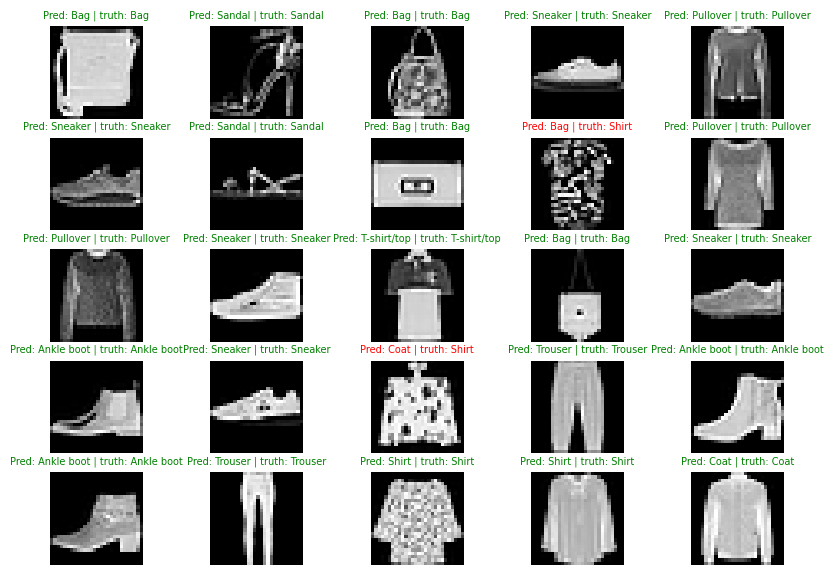

In [ ]:
plt.figure(figsize=(10, 7))
for i in range(25):
  plt.subplot(5,5,i+1)
  random_idx = torch.randint(0, len(test_data), size=[1]).item()
  image, label = test_data[random_idx]

  pred_logits = model(image.unsqueeze(dim=0).to(device))
  pred_prob = torch.softmax(pred_logits, dim=1)
  pred_label = class_names[pred_prob.argmax(dim=1)]
  truth_label = class_names[label]
  plt.imshow(image.squeeze(), cmap="gray")
  color = "green" if pred_label == truth_label else "red"
  plt.title(f"Pred: {pred_label} | truth: {truth_label}",color=color, fontsize=7 )
  plt.axis(False);

In [ ]:
!pip install torchmetrics

In [ ]:
y_preds = []
model.eval()
with torch.inference_mode():
  for X,y in tqdm(test_dataloader):
    X,y = X.to(device), y.to(device)
    pred_logits = model(X).argmax(dim=1)
    y_preds.append(pred_logits.to("cpu"))

y_preds = torch.cat(y_preds)


y_truth = torch.tensor([label for _, label in test_data])



  0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
type(y_preds), type(y_truth)

(torch.Tensor, torch.Tensor)

In [ ]:
from torchmetrics.classification import MulticlassConfusionMatrix
metric = MulticlassConfusionMatrix(num_classes=len(class_names))
conf_mat = metric(y_preds, y_truth)

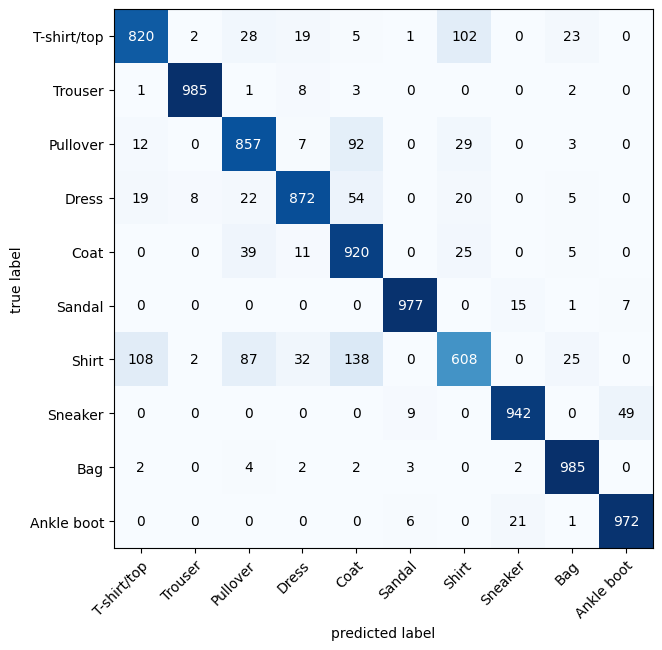

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(
    conf_mat = conf_mat.numpy(),
    class_names = class_names,
    figsize = (10,7)
)

## finally saving and loading the model

In [ ]:
# saving the model

torch.save(model.state_dict(), "model.pt")

In [ ]:
# loading the model
model_state_dict = torch.load("model.pt")
model = FashionMNISTModel(input_shape=1, hidden_units=10, output_shape=len(class_names))
model.load_state_dict(model_state_dict)